In [1]:
from pymongo import MongoClient
from pprint import pprint
import igraph
import numpy as np
import scipy
import pandas as pd
import sys
import pymongo
import gensim
import re
from gensim import models, corpora
from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from html import unescape
 

try:
    client = MongoClient('localhost', 27017) # host, port
except ConnectionFailure as e:
    sys.stderr.write("Could not connect to MongoDB: %s" % e)
    sys.exit(1)

c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# get database with all tweets
db = client.tweets_database

#client.tweets_database.filtered_tweets_noRetweets_english.drop()


filtered_noRetweets_english_onlyPersonal = client.tweets_database.filtered_noRetweets_english_onlyPersonal

client.tweets_database.collection_names()

['cleaned_tweets',
 'filtered_tweets_noRetweets_english',
 'users',
 'filtered_treated_tweets',
 'filtered_noRetweets_english_onlyPersonal',
 'tweets']

In [3]:
import sys
path = 'D:\A_AHNE1\Tweet-Classification-Diabetes-Distress\preprocess'

if path not in sys.path:
    sys.path.insert(0, path)
sys.path

from preprocess import Preprocess
prep = Preprocess()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Stagiaire2014\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Stagiaire2014\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Stagiaire2014\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
class CustomVectorizer(CountVectorizer):
    # overwrite the build_analyzer method, allowing one to
    # create a custom analyzer for the vectorizer
        def build_analyzer(self):
            # load stop words using CountVectorizer's built in method
            stop_words = self.get_stop_words()
            
            # create the analyzer that will be returned by this method
            def analyser(tweet):
                #print("tweet")
                #print(tweet)

                tweet = prep.replace_contractions(tweet)
                tweet = prep.replace_hashtags_URL_USER(tweet)
                tweet = prep.tokenize(tweet)
                tweet = prep.remove_punctuation(tweet)

                tweet = prep.preprocess_emojis(tweet)
                tweet = prep.preprocess_emoticons(tweet)
                tweet = prep.remove_non_ascii(tweet)
                tweet = prep.to_lowercase(tweet)

                tweet = prep.remove_stopwords(tweet)
                tweet = prep.lemmatize_verbs(tweet)
                tweet = prep.stem_words(tweet)
                tweet = [ x for x in tweet if x not in["diabet", "glucos", "insulin", "type", "1", "2", "", "get", "sugar", "would",
                                                      "go", "know", "take", "give", "say", "one", "could", "would", "people", "look",
                                                      "year", "test", "see", "oh", "via", "bitch", "daddi", "hi", "w", "b", "n", "c",
                                                      "ii", "dr", "rt", "bc", "ok", "think", "make"] ]

                return tweet
            
            return(analyser)

In [5]:
tweets = []
for tweet in filtered_noRetweets_english_onlyPersonal.find():
    tweets.append((tweet["id_str"], tweet["text"]))
    
tweets_list = [x for (id, x) in tweets]

len(tweets)

446097

In [6]:
# min_df : ignores terms that have a document frequency strictly lower than the given threshold (absolute counts)
# max_df : ignores terms that have a document frequency strictly higher than the given threshold (proportion of documents)
vectorizer_test = CustomVectorizer(min_df=5, max_df=0.9, 
                                     stop_words=None, lowercase=True, analyzer = 'word' )


In [7]:
tweets_preprocessed = vectorizer_test.fit_transform(tweets_list)

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 🔙 -> delete emoji :BACK_arrow:
INFO: No category set for emoji 🔛 -> delete emoji :ON!_arrow:
INFO: No category set for emoji 🔝 -> delete emoji :TOP_arrow:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001D051808>)
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: Could not replace emoticon: :3 of the word: 9:30 (<class 'KeyError'>, KeyError('9:30',), <traceback object at 0x000000001D0702C8>)
INFO: No category set for emoji ↪ -> delete emoji :left_arrow_curving_right:
INFO: No category set for emoji ↩ -> delete emoji :right_arrow_curving_left:
INFO: Could not replace emoticon: xp of the word: Unexpected (<class 'KeyError'>, KeyError('Unexpected

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💡 -> delete emoji :light_bulb:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 😈 -> delete emoji :smiling_face_with_horns:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001EA5C848>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback o

INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001E834D88>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001F8FE448>)
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🍟 -> delete emoji :french_fries:
INFO: No category set for emoji 🍊 -> delete emoji :tangerine:
INFO: No category set for emoji 🤡 -> delete emoji :clown_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😏 -> delet

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x000000001E875108>)
INFO: Could not replace emoticon: xp of the word: exploitative (<class 'KeyError'>, KeyError('exploitative',), <traceback object at 0x000000001F0C4408>)
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽

INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: No category set for emoji 👫 -> delete emoji :man_and_woman_holding_hands:
INFO: No category set for emoji ❓ -> delete emoji :question_mark:
INFO: No category set for emoji ❓ -> delete emoji :question_mark:
INFO: No category set for emoji 🍬 -> delete emoji

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ❔ -> delete emoji :white_question_mark:
INFO: No category set for emoji ❔ -> delete emoji :white_question_mark:
INFO: No category set for emoji ❔ -> delete emoji :white_question_mark:
INFO: No category set for emoji ❔ -> delete emoji :white_question_mark:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji ❔ -> delete emoji :white_question_mark:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001E9C0608>)
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: Could not replace emoticon: XP of the w

INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: Could not replace emoticon: xp of the word: unexpectedly (<class 'KeyError'>, KeyError('unexpectedly',), <traceback object at 0x000000001EBF6288>)
INFO: Could not replace emoticon: xp of the word: unexpectedly (<class 'KeyError'>, KeyError('unexpectedly',), <traceback object at 0x000000001EBF6288>)
INFO: No category set for emoji ✋ -> delete emoji :raised_hand:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:


INFO: Could not replace emoticon: :d of the word: :d (<class 'KeyError'>, KeyError(':d',), <traceback object at 0x000000001F92E6C8>)
INFO: No category set for emoji ✋ -> delete emoji :raised_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x000000001EC19488>)
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: Could not replace emoticon: xp of the word: NGHSInnovationExpo (<class 'KeyError'>, KeyError(

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001EBCFAC8>)
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x000000001F921488>)
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001EBCFB88>)
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001F921648>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>

INFO: No category set for emoji 🆗 -> delete emoji :OK_button:
INFO: No category set for emoji 🆒 -> delete emoji :COOL_button:
INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001EBDEFC8>)
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: Could not replace emoticon: xp of 

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001EF60B48>)
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('ex

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001F88C548>)
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😣 -> del

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: xp of the word: explosion (<class 'KeyError'>, KeyError('explosion',), <traceback object at 0x000000001F152448>)
INFO: Could not replace emoticon: :p of the word: :p (<class 'KeyError'>, KeyError(':p',), <traceback object at 0x000000001F152408>)
INFO: Could not replace emoticon: :p of the word: :p (<class 'KeyError'>, KeyError(':p',), <traceback object at 0x000000001F1526C8>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🍎 -> delete emoji :red_apple:
INFO: Could not replace emoticon: xp of the word: explanation (<class 'KeyError'>, KeyError('explanation',), <traceback object at 0x000000001F152BC8>)
INFO: Could not replace emoticon: xp of the word: explanation (<class 'KeyError'>, KeyError('explanation',), <traceback object at 0x000000001F153E88>)
INFO: Coul

INFO: Could not replace emoticon: xp of the word: Unexpected (<class 'KeyError'>, KeyError('Unexpected',), <traceback object at 0x000000001F145848>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: Could not replace emoticon: XP of the word: EXPOSED (<class 'KeyError'>, KeyError('EXPOSED',), <traceback object at 0x000000001F14B388>)
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 💝 -> delete emoji :heart_with_ribbon:
INFO: No category set for emoji 💝 -> delete emoji :heart_with_ribbon:
INFO: No category set fo

INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: xp of the word: experiment (<class 'KeyError'>, KeyError('experiment',), <traceback object at 0x000000001F145948>)
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: xp of the word: experiment (<class 'KeyError'>, KeyError('experiment',), <traceback object at 0x000000001ECBF988>)
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set f

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :w

INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: ) of the word: ); (<class 'KeyError'>, KeyError(');',), <traceback object at 0x000000001EC726C8>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001EED7E08>)
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: Could not replace emoticon: xp of the word: Explain (<class 'KeyError'>, KeyError('Explain',), <traceback obje

INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x000000001F58F5C8>)
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001F58F708>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001F58F888>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001F58F908>)


INFO: Could not replace emoticon: xp of the word: expenses (<class 'KeyError'>, KeyError('expenses',), <traceback object at 0x000000001F9FD808>)
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 📝 -> delete emoji :memo:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: xp of the word: explanation (<class 'KeyError'>, KeyError('explanation',), <traceback object at 0x000000001F9FDBC8>)
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No catego

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: Express (<class 'KeyError'>, KeyError('Express',), <traceback object at 0x000000001D3DF608>)
INFO: Could not replace emoticon: xp of the word: exposure (<class 'KeyError'>, KeyError('exposure',), <traceback object at 0x000000001D3DF848>)
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😩

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😓 -> delete emoji

INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: xp of the word: exploding (<class 'KeyError'>, KeyError('exploding',), <traceback object at 0x000000001EF57DC8>)
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001EF57508>)
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤐 -> delete emoji :zipper-mouth_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('e

INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji ♨ -> delete emoji :hot_springs:
INFO: No category set for emoji ♨ -> delete emoji :hot_springs:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: Could not replace emoticon: xp of the word: unexpired (<class 'KeyError'>, KeyError('unexpired',), <traceback object at 0x000000001EB80A48>)
INFO: Could not replace emot

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: Could not replace emoticon: xp of the word: expired (<class 'KeyError'>, KeyError('expired',), <traceback object at 0x000000001EFCA888>)
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🌼 -> delete emoji :blossom:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000001EFCAA08>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000001EFCA3C8>)
INFO: Could not replace emoticon: xp of the word: expresstechie (<class 'KeyError'>, KeyError('expresstechie',), <traceback object at 0x000000001EB64848>)
INFO: No category set for emoji 🌸 -> delete emoji :cherry_

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍿 -> delete emoji :popcorn:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji ‼ -> 

INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001EFDCD08>)
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set f

INFO: Could not replace emoticon: xp of the word: exptemely (<class 'KeyError'>, KeyError('exptemely',), <traceback object at 0x000000001EFDD4C8>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001EFDC188>)
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x000000001EFCA9C8>)
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001D3B76C8>)
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🏥 -> delete emoji :hospital:
INFO: No c

INFO: Could not replace emoticon: xp of the word: explodes (<class 'KeyError'>, KeyError('explodes',), <traceback object at 0x000000001D3B7BC8>)
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: Could not replace emoticon: xp of the word: expressing (<class 'KeyError'>, KeyError('expressing',), <traceback object at 0x000000001EDBD408>)
INFO: Could not replace emoticon: xp of the word: Expressing (<class 'KeyError'>, KeyError('Expressing',), <traceback object at 0x000000001EDBD308>)
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🥘 -> delete emoji :shallow_pan_of_food:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x000000001EDC6788>)
INFO: No ca

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: xp of the word: expiring (<class 'KeyError'>, KeyError('expiring',), <traceback object at 0x000000001EDCBE48>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: Could not replace emoticon: xp of the word: experiment (<class 'KeyError'>, KeyError('experiment',), <traceback object at 0x000000001EDCB788>)
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback ob

INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: Could not replace emoticon: :3 of the word: 3:30 (<class 'KeyError'>, KeyError('3:30',), <traceback object at 0x000000001D390208>)
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: Could not replace emoticon: :3 of the word: 4:30 (<class 'KeyError'>, KeyError('4:30',), <traceback object at 0x000000001EDDEDC8>)
INFO: No category set for emoji 🥑 -> delete emoji :avocado:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: Could not replace emoticon: :p of the word: :p (<class 'KeyError'>, KeyError(':p',), <traceback object at 0x000000001D39A8C8>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ⌚ 

INFO: No category set for emoji 🍗 -> delete emoji :poultry_leg:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: Could not replace emoticon: xp of the word: exploded (<class 'KeyError'>, KeyError('exploded',), <traceback object at 0x000000001F173108>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 🍏 -> delete emoji :green_apple:
INFO: No category set for emoji 🥗 -> delete emoji :green_salad:
INFO: No category set for emoji 🍗 -> delete emoji :poultry_leg:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: Could not replace emot

INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 💸 -> delete emoji :money_with_wings:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx',), <traceback object at 0x000000001EF190C8>)
INFO: No cat

INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: Could not replace emoticon: xp of the word: Experiment (<class 'KeyError'>, KeyError('Experiment',), <traceback object at 0x000000001EF10848>)
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001EEE4308>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001EF1A108>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🚑 -> delete emoji :ambulance:
INFO: No category set for emoji 💩 -> de

INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🌸 -> delete emoji :cherry_blossom:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: experiment (<class 'KeyError'>, KeyError('experiment',), <traceback object at 0x000000001F09E308>)
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: Could not replace emoticon: xp of the word: explosion (<c

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001F074BC8>)
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001EB90B88>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete 

INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001D390A48>)
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001F074888>)
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001F074408>)
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('exp

INFO: Could not replace emoticon: xp of the word: experienced (<class 'KeyError'>, KeyError('experienced',), <traceback object at 0x000000001EE7EA48>)
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 🙍 -> delete emoji :person_frowning:
INFO: No category set for emoji 🙎 -> delete emoji :person_pouting:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 🙍 -> delete emoji :person_frowning:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 💤 -> delete emoji :zzz:
INFO: No category set for emoji 💤 -> delete emoji :zzz:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_

INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001EE95D08>)
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍨 -> delete emoji :ice_cream:
INFO: No category set for emoji 🍧 -> delete emoji :shaved_ice:
INFO: No category set for emoji 🍮 -> delete emoji :custard:
INFO: No category set for emoji 🍯 -> delete emoji :honey_pot:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: Could not replace emoticon: xp of the word: experienced (<class 'KeyError'>, KeyError('experienced',), <traceback object at 0x000000001EE8E808>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_fac

INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001D34E988>)
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: xp of the word: expansion (<class 'KeyError'>, KeyError('expansion',), <traceback object at 0x000000001D343B08>)
INFO: Could not replace emoticon: dx of the word: dxb (<class 'KeyError'>, KeyError('dxb',), <traceback object at 0x000000001D34EBC8>)
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🍓 -> delete emoji :strawberry:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No categor

INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001EE8EE08>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: Could not replace emoticon: xd of the word: soapboxderby (<class 'KeyError'>, KeyError('soapboxderby',), <traceback object at 0x000000001D34C388>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001D34C708>)
INFO: No category set for emoji 🍍 -> delete emoji :pineapple:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤔 -> delet

INFO: Could not replace emoticon: xp of the word: Expat (<class 'KeyError'>, KeyError('Expat',), <traceback object at 0x000000001EE24FC8>)
INFO: No category set for emoji 🍶 -> delete emoji :sake:
INFO: No category set for emoji 🍶 -> delete emoji :sake:
INFO: Could not replace emoticon: xp of the word: AliExpress (<class 'KeyError'>, KeyError('AliExpress',), <traceback object at 0x000000001EE24B48>)
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x000000001EE24848>)
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: xp of the word: Expat (<class 'KeyError'>, KeyError('Expat',), <traceback object at 0x000000001EE24188>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😅 -> delete

INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001EE49FC8>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000001EE8EF88>)
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: experiences (<class 'KeyError'>, KeyError('experiences',), <traceback object at 0x000000001EE49F88>)
INFO: Could not replace emoticon: xp of the word: expertise (<class 'KeyError'>, KeyError('expertise',), <traceback object at 0x00000000

INFO: Could not replace emoticon: xp of the word: unexplainable (<class 'KeyError'>, KeyError('unexplainable',), <traceback object at 0x000000001EDFC9C8>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: Could not replace emoticon: xp of the word: unexploded (<class 'KeyError'>, KeyError('unexploded',), <traceback object at 0x000000001EDFCBC8>)
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001EDFCDC8>)
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No catego

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001EDE6708>)
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 😎 -> delete emoji 

INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001EE16A88>)
INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001EDF3708>)
INFO: No category set for emoji ⚡ -> delete emoji :high_voltage:
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x000000001EDF3348>)
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001EE16588>)
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x000000001EDF3348>)
INFO: Could not replace emoticon: xp o

INFO: Could not replace emoticon: xp of the word: experienced (<class 'KeyError'>, KeyError('experienced',), <traceback object at 0x000000001F106388>)
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♥ -

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji ⬅ -> delete emoji :left_arrow:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x000000001F0E0D88>)
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🥛 -> delete emoji :glass_of_milk:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: Could not replace emoticon: xp of the word: Explains (<

INFO: Could not replace emoticon: ) of the word: ); (<class 'KeyError'>, KeyError(');',), <traceback object at 0x000000001F107808>)
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 🍏 -> delete emoji :green_apple:
INFO: No category set for emoji 🍎 -> delete emoji :red_apple:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: xp of the word: Expat (<class 'KeyError'>, KeyError('Expat',), <traceback object at 0x000000001EE24108>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: xp of the word: Expat (<class 'KeyError'>, KeyError('Expat',), <traceback object at 0x000000001EE28308>)
INFO: No cat

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emo

INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001EED3288>)
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: Could not replace emoticon: xp of the word: expenditures (<class 'KeyError'>, KeyError('expenditures',), <traceback object at 0x000000001D299808>)
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_poin

INFO: No category set for emoji 🌺 -> delete emoji :hibiscus:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001D2998C8>)
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: ) of the word: ):

INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001D2AA8C8>)
INFO: Could n

INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x000000001D2AA508>)
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: Could not replace emoticon: xp of the word: Experiment (<class 'KeyError'>, KeyError('Experiment',), <traceback object at 0x000000001F0E9F48>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001F597088>)
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: N

INFO: No category set for emoji 😈 -> delete emoji :smiling_face_with_horns:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: N

INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: Could not replace emoticon: ) of the word: ;') (<class 'KeyError'>, KeyError(";')",), <traceback object at 0x000000001F041788>)
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001F041B88>)
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001F0410C8>)
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emo

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 📞 -> delete emoji :telephone_receiver:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤥 -> delete emoji :lying_face:
INFO: No category set for emoji 🤥 -> delete emoji :lying_face:
INFO: No category set for emoji 🤥 -> delete emoji :lying_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000001F04DF88>)
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',)

INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x000000001F03FAC8>)
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: Could not replace emoticon: DX of the word: DXAmsterdam (<class 'KeyError'>, KeyError('DXAmsterdam',), <traceback object at 0x000000001F03FD88>)
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x000000001F054288>)
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for e

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x000000001F03EA48>)
INFO: Could not replace emoticon: : of the word: <:: (<class 'KeyError'>, KeyError('<::',), <traceback object at 0x000000001F03EA48>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001F03E848>)
INFO: No category set f

INFO: No category set for emoji 🏣 -> delete emoji :Japanese_post_office:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🏩 -> delete emoji :love_hotel:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001F7252C8>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for 

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🍞 -> delete emoji :bread:
INFO: No category set for emoji 🥔 -> delete emoji :potato:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: 0:3 of the word: 10:30 (<class 'KeyError'>, KeyError('10:30',), <traceback object at 0x000000001F737F48>)
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 🏃 -> delete emoji :person_running:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_fa

INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: Could not replace emoticon: xp of the word: explained (<class 'KeyError'>, KeyError('explained',), <traceback object at 0x000000001F747248>)
INFO: Could not replace emoticon: dx of the word: dxed (<class 'KeyError'>, KeyError('dxed',), <traceback object at 0x000000001F747B08>)
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001F743C48>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🍅 -> delete emoji :tomato:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001F72

INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001F725DC8>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001F72BCC8>)
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001D5A3588>)
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001D5A3908>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001D5A3908>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyErro

INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🏩 -> delete emoji :love_hotel:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: xp of the word: expenses (<class 'KeyError'>, KeyError('expenses',), <traceback object at 0x000000001D5B1548>)
INFO: Could not replace emoticon: xp of the word: expenses (<class 'KeyError'>, KeyError('expenses',), <traceback object at 0x000000001D5B17C8>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🆗 -> delete emoji :OK_button:
INFO: No category set for emoji 🙄 -> delete emoj

INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: Could not replace emoticon: xp of the word: expand (<class 'KeyError'>, KeyError('expand',), <traceback object at 0x000000001D5A3588>)
INFO: Could not replace emoticon: : of the word: (: (<class 'KeyError'>, KeyError('(:',), <traceback object at 0x000000001D5AB408>)
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000001D5ABFC8>)
INFO: No category set for emoji 💆 -> delete emoji :person_getting_massage:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx',), <traceback object at 0x000000001D5ABD48>)
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: Could not replace emoticon: xp of the word: explaining (<class 'KeyError'>, KeyError('explaining',), <traceback objec

INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: Could not replace emoticon: xp of the word: UStaxpayers (<class 'KeyError'>, KeyError('UStaxpayers',), 

INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 💒 -> delete emoji :wedding:
INFO: No category set for emoji 👰 -> delete emoji :bride_with_veil:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji ⚔ -> delete emoji :crossed_swords:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 🚗 -> delete emoji :automobile:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji ⁉ -> delete 

INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000001D4C2208>)
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000001D4F10C8>)
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: N

INFO: Could not replace emoticon: :d of the word: :d (<class 'KeyError'>, KeyError(':d',), <traceback object at 0x000000001D4D3188>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x000000001D4CAE88>)
INFO: Could not replace emoticon: :3 of the word: 6:30 (<class 'KeyError'>, KeyError('6:30',), <traceback object at 0x000000001D4CAE88>)
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001D4CA5C8>)
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🍫

INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001D302A88>)
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🔫 -> delete emoji :pistol:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> de

INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001D4CA488>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: xp of the word: expenditures (<class 'KeyError'>, KeyError('expenditures',), <traceback object at 0x000000001D316E48>)
INFO: No category set for emoji 🙃 -> delet

INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji 🕌 -> delete emoji :mosque:
INFO: No category set for emoji 🐍 -> delete emoji :snake:
INFO: No category set for emoji 🐀 -> delete emoji :rat:
INFO: No category set for emoji 🤡 -> delete emoji :clown_face:
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x000000001D32A308>)
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: Could not replac

INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001D4DE508>)
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: xp of the word: explain (<cl

INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 🏣 -> delete emoji :Japanese_post_office:
INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🏩 -> delete emoji :love_hotel:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 💰 -> delete emoji :money_bag:
INFO: No category s

INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👵 -> delete emoji :old_woman:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:


INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: Could not replace emoticon: xp of the word: expose (<class 'KeyError'>, KeyError('expose',), <traceback object at 0x000000001F7A6648>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 👀 -

INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: Could not replace emoticon: xD of the word: xD (<class 'KeyError'>, KeyError('xD',), <traceback object at 0x000000001F7BD2C8>)
INFO: No category set for emoji 🍀 -> delete emoji :four_leaf_clover:
INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001F7BA048>)
INFO: No category set for emoji 😬 -> de

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :hear

INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001F7B5D88>)
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: Could not replace emoticon: xp of the word: explore (<class 'KeyError'>, KeyError('explore',), <traceback object at 0x000000001F7A60C8>)
INFO: No category set for emoji 😨 -> delete emoji :fearful_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001F008688>)
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001F008488>)
INFO: Could not replace emoti

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001EFEC548>)
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😨 -> delete emoji :fearful_face:
INFO: Could not replace emoticon: 8d of the word: 108daysfancydress (<class 'KeyError'>, KeyError('108daysfancydress',), <traceback object at 0x000000001EFECBC8>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set f

INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001F01E9C8>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🏺 -> delete emoji :amphora:
INFO: No category set for emoji ⚱ -> delete emoji :funeral_urn:
INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INF

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: xp of the word: unexpected (<class 'KeyError'>, KeyError('unexpected',), <traceback object at 0x000000001D2CE988>)
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji ➕ -> delete emoji :heavy_plus_sign:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji ➕ -> delete emoji :heavy_plus_sign:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🍁 -> delete emoji :maple_leaf:

INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 🍨 -> delete emoji :ice_cream:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyE

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001D2E2808>)
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with

INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001D2D9F08>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001D2EF0C8>)
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤤 -> delete emoji

INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001D2D9F88>)
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji ♨ -> delete emoji :hot_springs:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🌞 -> delete emoji :sun_with_face:
INFO: No category set for emoji 📈 -> delete emoji :chart_increasing:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category

INFO: Could not replace emoticon: xD of the word: xD (<class 'KeyError'>, KeyError('xD',), <traceback object at 0x000000001D2D9088>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001D57AE48>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🔫 -> delete emoji :pistol:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for em

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x000000001D566108>)
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: Could not replace emoticon: :p of the word: :p (<class 'KeyError'>, KeyError(':p',), <traceback object at 0x000000001D571F88>)
INFO: Could not replace emoticon: xD of the word: xD (<class 'KeyError'>, KeyError('xD',), <traceback object at 0x000000001D2D9DC8>)
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: Could not r

INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🍟 -> delete emoji :french_fries:
INFO: Could not replace emoticon: xp of the word: explaining (<class 'KeyError'>, KeyError('explaining',), <traceback object at 0x000000001D561D88>)
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001D566B48>)
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🌅 -> delete emoji :sunrise:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😒 -> delete emoji 

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoj

INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🐙 -> delete emoji :octopus:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
I

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: Could not replace emoticon: 0:3 of the word: 10:30 (<class 'KeyError'>, KeyError('10:30',), <traceback object at 0x000000001F6D70C8>)
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the wor

INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: Could not replace emoticon: xp of the word: expiry (<class 'KeyError'>, KeyError('expiry',), <traceback object at 0x000000001D2EFBC8>)
INFO: Could not replace emoticon: :3 of the word: 15:32 (<class 'KeyError'>, KeyError('15:32',), <traceback object at 0x000000001F6D7F08>)
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001D570088>)
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: 

INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001F6F1088>)
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001EFE3C88>)
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😜 ->

INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji 🚫 -> delete emoji :prohibited:
INFO: No category set for emoji 🔆 -> delete emoji :bright_button:
INFO: No category set for emoji 🔆 -> delete emoji :bright_button:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: Could not 

INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001F76F2C8>)
INFO: No category set for emoji ▪ -> delete emoji :black_small_square:
INFO: No category set for emoji © -> delete emoji :copyright:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delet

INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: Explain (<class 'KeyError'>, KeyError('Explain',), <traceback object at 0x000000001F761CC8>)
INFO: No category set for emoji 🙄 -> delete emoji :fa

INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🍾 -> delete emoji :bottle_with_popping_cork:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001F7670C8>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:

INFO: No category set for emoji 🦄 -> delete emoji :unicorn_face:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001D57A208>)
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🐑 -> delete emoji :sheep:
INFO: No category set for emoji 🐑 -> delete emoji :sheep:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001F77C808>)
INFO: Could not replace emoticon: xp of the word: express (<class 'KeyError'>, KeyError('express',), <traceback object at 0x000000001F6F7188>)
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out

INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: Could not replace emoticon: 8d of the word: 108daysfancydress (<class 'KeyError'>, KeyError('108daysfancydress',), <traceback object at 0x000000001F774808>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000001F754888>)
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000001D5626C8>)
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001F774748>)
INFO: No category set for emoji 📆 -> delete emoji :tear-off_calendar:
INFO: No category set for emoji 📝 -> delete emoji :memo:
INFO: No category set for emoji ❣ -> delete emoji :heavy_heart_exclamation:
INFO: No categor

INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001D539A88>)
INFO: Could not replace emoticon: : of the word: |: (<class 'KeyError'>, KeyError('|:',), <traceback object at 0x000000001D539A88>)
INFO: Could not replace emoticon: xp of the word: Express (<class 'KeyError'>, KeyError('Express',), <traceback object at 0x000000001D539B48>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001D539D88>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :m

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: Could not replace emoticon: xp of the word: Expected (<class 'KeyError'>, KeyError('Expected',), <traceback object at 0x000000001D513B48>)
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: Could not replace emoticon: xp of the word: Experiment (<class 'KeyError'>, KeyError('Experiment',), <traceback object at 0x000000001D513E88>)
INFO: No category set for emoji 😐 -> delete emoji :neutral_fa

INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001F77C188>)
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💃 -> delete emoji :woman_dancing:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙄 

INFO: No category set for emoji 🔵 -> delete emoji :blue_circle:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji ⚫ -> delete emoji :black_circle:
INFO: No category set for emoji 🔴 -> delete emoji :red_circle:
INFO: No category set for emoji 🔵 -> delete emoji :blue_circle:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001D513588>)
INFO: No category set for emoji 🐝 -> delete emoji :honeybee:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001D513588>)
INFO: No category set for emoji 😟 -> delete emoji :worried_face:


INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001D52A7C8>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001D52A8C8>)
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001D52A148>)
INFO: No category set for emoji 🤖 -> delete emoji :robot_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: Could not replace emoticon: :3 of the word: 5:30 (<class 'KeyError'>, KeyError('5:30',), <traceback object at 0x000000001D526CC8>)
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001D526388>)
INFO: No category set for emoji 

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🚚 -> delete emoji :delivery_truck:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: Could not replace emoticon: xp of the word: explanation (<class 'KeyError'>, KeyError('explanation',), <traceback object at 0x000000001D513788>)
INFO: No category set for emoji 🔶 -> delete emoji :large_orange_diamond:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: t.T of t

INFO: Could not replace emoticon: xp of the word: expertise (<class 'KeyError'>, KeyError('expertise',), <traceback object at 0x000000001D47DF48>)
INFO: No category set for emoji 🌍 -> delete emoji :globe_showing_Europe-Africa:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🍉 -> delete emoji :watermelon:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001D47D9C8>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🍻 -> delete emoji :clinking_beer_mugs:
INFO: Could not replace emoticon: xp of the word: 

INFO: Could not replace emoticon: xp of the word: express (<class 'KeyError'>, KeyError('express',), <traceback object at 0x000000001F754F08>)
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: xp of the word: express (<class 'KeyError'>, KeyError('express',), <traceback object at 0x000000001D515CC8>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001D515C48>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: xp of the word: expressed (<class 'KeyError'>, KeyError('expressed',), <traceback object at 0x000000001D47FB08>)
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category 

INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🚴 -> delete emoji :person_biking:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤼 -> delete emoji :people_wrestling:
INFO: No category set for emoji 🍎 -> delete emoji :red_apple:
INFO: Could not replace emoticon: xp of the word:

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: Could not replace emoticon: xp of the word: exposing (<class 'KeyError'>, KeyError('exposing',), <traceback object at 0x000000001D46EBC8>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🥓 -> delete emoji :bacon:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoj

INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: Could not replace emoticon: xp of the word: expecting (<class 'KeyError'>, KeyError('expecting',), <traceback object at 0x000000001D463608>)
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001D4638C8>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: Could not replace emoticon: xp of the word: Express (<class 'KeyError'>, KeyError('Express',), <traceback object at 0x000000001D4429C8>)
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: Could not replace emoticon: xp of the word: Express (<class 'KeyError'>, KeyError('Express',), <traceback object at 0x000000001D442408>)
INFO: No c

INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: Could not replace emoticon: :3 of the word: 6:30 (<class 'KeyError'>, KeyError('6:30',), <traceback object at 0x000000001F6049C8>)
INFO: Could not replace emoticon: xp of the word: exploreyourtype (<class 'KeyError'>, KeyError('exploreyourtype',), <traceback object at 0x000000001F604C48>)
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: Could not replace emoticon: xp of the word: exposed (<class 'KeyError'>, KeyError('e

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤡 -> delete emoji :clown_face:
INFO: No category set for emoji 🤡 -> delete emoji :clown_face:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 🚬 -> delete emoji :cigarette:
INFO: No category set for emoji 🚬 -> delete emoji :cigarette:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🍟 -> delete emoji :french_fries:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for e

INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😷 -> delete

INFO: Could not replace emoticon: xp of the word: expecting (<class 'KeyError'>, KeyError('expecting',), <traceback object at 0x000000001F605488>)
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001F5E3488>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugg

INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001F5D1E88>)
INFO: No category set for emoji 🍞 -> delete emoji :bread:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji 🐬 -> delete emoji :dolphin:
INFO: No category set for emoji 🦄 -> delete emoji :unicorn_face:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 🦋 -> delete emoji :butterfly:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍀 -> delete emoji :four_leaf_clover:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🌈 -> delete emoji :rainbow:
INFO: No category set for emoji 🍦 -> de

INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001F60B488>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: Could not replace emoticon: ) of the word: )-: (<class 'KeyError'>, KeyError(')-:',), <traceback object at 0x000000001F605988>)
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_foo

INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001F60F7C8>)
INFO: Could not replace emoticon: xp of the word: exposed (<class 'KeyError'>, KeyError('exposed',), <traceback 

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x000000001D4B6408>)
INFO: Could not replace emoticon: dx of the word: dxd (<class 'KeyError'>, KeyError('dxd',), <traceback object at 0x000000001D4B6D48>)
INFO: Could not replace emoticon: xp of the word: expenses (<class 'KeyError'>, KeyError('expenses',), <traceback object at 0x000000001F60BD48>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😛 -> delete 

INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001D4AA408>)
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x000000001D4AA408>)
INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x000000001F5F4B88>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💭 -> delete emoji :thought_balloon:
INFO: No category set for emoji 🍴 -> delete emoji :fork_and_knife:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: Could not replace emoticon: xp of the word: experiment (<class 'KeyError'>, KeyError('experiment',), <traceb

INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001D4B6B08>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: Could not replace emoticon: xp of the word: experiences (<class 'KeyError'>, KeyError('experiences',), <traceback object at 0x000000001D48D108>)
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 🍍 -> delete emoji :pineapple:
INFO: No category set for emoji 🍍 -> delete emoji :pineapple:
INFO: No category set for emoji 🍍 -> delete emoji :pineapple:
INFO: No category set for emoji 🙄 -> delete emoji :face_wit

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001D4A5C48>)
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001F60B848>)
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001F60B0C8>)
INFO: No category set for emoji 🍺 -> delete emoji :beer_mug:
INFO: No category set for emoji 🍺 -> delete emoji :beer_mug:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🔫 -> delete emoji :pistol:
INFO: No category set for emoji 😔 -> delete

INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001D492748>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: xp of the word: Experience (<class 'KeyError'>, KeyError('Experience',), <traceback object at 0x000000001D487788>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: xp of the word: Experience (<class 'KeyError'>, KeyError('Experience',), <traceback object at 0x000000001D492748>)
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: Could not replace emoticon: xp of t

INFO: No category set for emoji 👐 -> delete emoji :open_hands:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x000000001D4819C8>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: experiment (<class 'KeyError'>, KeyError('experiment',), <traceback object at 0x000000001D481388>)
INFO: No category set for

INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001F651988>)
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001F651F08>)
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001F651E88>)
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x000000001F685208>)
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001F685A88>)
INFO: No category set for emoji 🍞 -> delete emoji :bread:
INFO: No category set for emoji 🥖 -> delete emoji :baguette_bread:
INFO: No category set for emoji 🥞 -> delete emoji :pancakes:


INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001D4928C8>)
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',),

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001F685BC8>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: Experiment (<class 'KeyError'>, KeyError('Experiment',), <traceback object at 0x000000001D499B08>)
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: Could not replace emoticon: xp of the word: experiment (<class 'KeyError'>, KeyError('experiment',), <traceback object at 0x000000001F672DC8>)
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: Could not replace emoticon: ) of the word: (516)248-8188 (<class 'KeyError'>, KeyError('(516)248-8188',), <traceback object at 0x000000001F672808>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
IN

INFO: Could not replace emoticon: xp of the word: JudgingFromMyExperience (<class 'KeyError'>, KeyError('JudgingFromMyExperience',), <traceback object at 0x000000001D499188>)
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: :3 of the word: 7:30 (<class 'KeyError'>, KeyError('7:30',), <traceback object at 0x000000001F670E08>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: Could not replace emoticon: xp of the word: explosion (

INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001F6803C8>)
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001F680CC8>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_ast

INFO: No category set for emoji ☑ -> delete emoji :ballot_box_with_check:
INFO: No category set for emoji 🐘 -> delete emoji :elephant:
INFO: Could not replace emoticon: :3 of the word: 7:30 (<class 'KeyError'>, KeyError('7:30',), <traceback object at 0x000000001F6803C8>)
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 😴 -> delete emoji :s

INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x000000001F6C1248>)
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback obje

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: Could not replace emoticon: :p of the word: :p (<class 'KeyError'>, KeyError(':p',), <traceback object at 0x000000001F6BBC88>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medi

INFO: Could not replace emoticon: :p of the word: :p (<class 'KeyError'>, KeyError(':p',), <traceback object at 0x000000001F6CDA88>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: Could not replace emoticon: :3 of the word: 9:30 (<class 'KeyError'>, KeyError('9:30',), <traceback object at 0x000000001F6AF148>)
INFO: No category set for emoji 🐍 -> delete emoji :snake:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🐾 -> delete emoji :paw_prints:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoj

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🍟 -> delete emoji :french_fries:
INFO: No category set for emoji ☁ -> delete emoji :cloud:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 🍑 -> delete emoji :peach:
INFO: No category set for emoji 🐞 -> delete emoji :lady_beetle:
INFO: No category set for emoji ☁ -> delete emoji :cloud:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 🍑 -> delete emoji :peach:
INFO: No category set for emoji 🐞 -> delete emoji :lady_beetle:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001F6AF788>)
INFO: No category set for emoji ☁ -> delete emoji :cloud:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 🍑 -> delete 

INFO: Could not replace emoticon: xp of the word: expired (<class 'KeyError'>, KeyError('expired',), <traceback object at 0x000000001F69D588>)
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001F672888>)
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: Could not replace emoticon: ) of the word: (216) 965-0646 (<class 'KeyError'>, KeyError('(216) 965-0646',), <traceback object at 0x000000001F69D5C8>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for 

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙉 -> delete emoji :hear-no-evil_monkey:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000001F698808>)
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000001F6987C8>)
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set 

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: Could not replace emoticon: xp of the word: inexpensive (<class 'KeyError'>, KeyError('inexpensive',), <traceback object at 0x0000000020A5FA08>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback objec

INFO: No category set for emoji 👈 -> delete emoji :backhand_index_pointing_left:
INFO: No category set for emoji ☄ -> delete emoji :comet:
INFO: No category set for emoji ⛱ -> delete emoji :umbrella_on_ground:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤸 -> delete emoji :person_cartwheeling:
INFO: No category set for emoji 🤸 -> delete emoji :person_cartwheeling:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: xp of the word: expand (<class 'KeyError'>, KeyError('expand',), <traceback object at 0x0000000020A5DE88>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: qq of the word: Haqq (<class 'KeyError'>, KeyError('Haqq',), <traceback object at 0x0000000020A5D788>)
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏿 -> delete emoji :dark_

INFO: No category set for emoji 👢 -> delete emoji :woman’s_boot:
INFO: No category set for emoji 👡 -> delete emoji :woman’s_sandal:
INFO: No category set for emoji 👠 -> delete emoji :high-heeled_shoe:
INFO: No category set for emoji 👟 -> delete emoji :running_shoe:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
I

INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji ▶ -> delete emoji :play_but

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤔 -> delete

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000001D4AAF08>)
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 🐸 -> delete emoji :frog_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x0000000020A43488>)
INFO: No category set for emoji 🐈 -> delete emoji :cat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
I

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: Could not replace emoticon: :d of the word: :d (<class 'KeyError'>, KeyError(':d',), <traceback object at 0x0000000020A45F08>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: Could not replace emoticon: xp of the word: experiencing (<class 'KeyError'>, KeyError('experiencing',), <traceback object at 0x0000000020A5D108>)
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x0000000020A57308>)
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👌 ->

INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: Could not replace emoticon: 8d of the word: 108daysfancydress (<class 'KeyError'>, KeyError('108daysfancydress',), <traceback object at 0x0000000020A57908>)
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: Could not replace emoticon: Xp of the word: Xpress (<class 'KeyError'>, KeyError('Xpress',), <traceback object at 0x0000000020A43E88>)
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😨 

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: :3 of the word: 1:30 (<class 'KeyError'>, KeyError('1:30',), <traceback object at 0x000000001F632248>)
INFO: No category set for emoji 🌸 -> delete emoji :cherry_blossom:
INFO: No category set for emoji 🌸 -> delete emoji :cherry_blossom:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🌷 -> delete emoji :tulip:
INFO: No category set for emoji 🌷 -> delete emoji :tulip:
INFO: No category set for emoji 🌷 -> delete emoji :tulip:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001F64DE48>)
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INF

INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: Could not replace emoticon: xp of the word: experie (<class 'KeyError'>, KeyError('experie',), <traceback object at 0x000000001F6311C8>)
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 🍃 -> delete emoji :leaf_fluttering_in_wind:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 🍃 -> delete emoji :leaf_fluttering_in_wind:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 🍃 -> delete emoji :leaf_fluttering_in_wind:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 🍃 -> delete emoji :leaf_fluttering_in_wind:
INFO: No category set for emoji 🌱 -> delete emoji :seedling:
INFO: No category set for emoji 🍃 -> delete emoji :leaf_fluttering_in_wind:
INFO: No category set for emoji

INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji ❄ -> delete emoji :snowflake:
INFO: No category set for emoji 🍧 -> delete emoji :shaved_ice:
INFO: No category set for emoji 🍨 -> delete emoji :ice_cream:
INFO: No category set for emoji 💎 -> delete emoji :gem_stone:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No c

INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: Could not replace emoticon: xp of the word: Expert (<class 'KeyError'>, KeyError('Expert',), <traceback object at 0x000000001F62A288>)
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ⚖ -> delete emoji :balance_scale:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: N

INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🅱 -> delete emoji :B_button_(blood_type):
INFO: No category set for emoji 🅱 -> delete emoji :B_button_(blood_type):
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: Could not replace emoticon: :3 of the word: 4:30 (<class 'KeyError'>, KeyError('4:30',), <traceback object at 0x000000001F647788>)
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: 0:3 of the word: 10:30 (<class 'KeyError'>, KeyError('10:30',), <traceback object at 0x000000001F6104C8>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x000000001F635448>)
INFO: Could not replace emoticon: xp of the word: explains (

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete em

INFO: Could not replace emoticon: xp of the word: explaining (<class 'KeyError'>, KeyError('explaining',), <traceback object at 0x0000000020113B48>)
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: Could not replace emoticon: xp of the word: experiencing (<class 'KeyError'>, KeyError('experiencing',), <traceback object at 0x0000000020113808>)
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji

INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000002011EB88>)
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_a

INFO: Could not replace emoticon: ) of the word: (216) 965-0646 (<class 'KeyError'>, KeyError('(216) 965-0646',), <traceback object at 0x000000002011E308>)
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🍴 -> delete emoji :fork_and_knife:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: Could not replace emoticon: xp of the word: expectations (<class 'KeyError'>, KeyError('expectations',), <traceback object at 0x000000002011EBC8>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INF

INFO: Could not replace emoticon: xD of the word: xD (<class 'KeyError'>, KeyError('xD',), <traceback object at 0x0000000020127D08>)
INFO: No category set for emoji 👸 -> delete emoji :princess:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: xp of the word: explosion (<class 'KeyError'>, KeyError('explosion',), <traceback object at 0x0000000020127848>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: Could not replace emoticon: xD of the word: VanexDjeeta (<class 'KeyError'>, KeyError('VanexDjeeta',), <traceback object at 0x000000001F6175C8>)
INFO: No category set for emoji 🙈 -> delete

INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: Could not replace emoticon: xp of the word: unexpected (<class 'KeyError'>, KeyError('unexpected',), <traceback object at 0x0000000020124508>)
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💁 -> delete em

INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🏊 -> delete emoji :person_swimming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No categ

INFO: No category set for emoji 🎈 -> delete emoji :balloon:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x0000000020133808>)
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x0000000020133A08>)
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x0000000020133F48>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: xp of the word: expands (<class 'KeyError'>, KeyError('expands',), <traceback object at 0x00000000201243C8>)
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set

INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🍰 -> delete emoji :sho

INFO: Could not replace emoticon: xp of the word: expired (<class 'KeyError'>, KeyError('expired',), <traceback object at 0x000000002013C708>)
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: Could not replace emoticon: :d of the word: :d (<class 'KeyError'>, KeyError(':d',), <traceback object at 0x0000000020139348>)
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x000000002013CB08>)
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x000000002013CB08>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: Could not replace emoticon: xp of the word: explosive (<class 'KeyError'>, KeyError('explosive',), <traceback object at 0x0000000020148148>)
INFO: Could not replace emoticon: :3 of the word: 4:30 (<class 'KeyError'>, KeyError('4:30',), <traceback object at 0x0000000020143AC8>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xd of the word: alexdorame (<class 'KeyError'>, KeyError('alexdorame',), <traceback object at 0x0000000020148248>)
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: Could not replace emoticon: 8d of the word: u2018di (<class 'KeyError'>, KeyError('u2018di',), <traceback object at 0x0000000020143E88>)
INFO: No category set for emoji 

INFO: Could not replace emoticon: Xp of the word: HealthXph (<class 'KeyError'>, KeyError('HealthXph',), <traceback object at 0x0000000020149E08>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: Could not replace emoticon: xp of the word: Experiment (<class 'KeyError'>, KeyError('Experiment',), <traceback object at 0x000000

INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: Could not replace emoticon: xp of the word: Experienced (<class 'KeyError'>, KeyError('Experienced',), <traceback object at 0x0000000020149E08>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000002014E0C8>)
INFO: No category set for emoji 👏 -> delete emoji :clapping_ha

INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000002014E788>)
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x0000000020149E48>)
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🍑 -> delete emoji :peach:
INFO: 

INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🍆 -> delete emoji :eggplant:
INFO: No category set for emoji 📱 -> delete emoji :mobile_phone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji 🏥 -> delete emoji :hospital:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category se

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ⛱ -> delete emoji :umbrella_on_ground:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x0000000020167148>)
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩

INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x00000000201648C8>)
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 🏖 -> delete emoji :beach_with_umbrella:
INFO: No category set for emoji ✈ -> delete emoji :airplane:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000002015A8C8>)
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 🌻 -> delete emoji :sunflower:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😼 -> delete emoji :cat_face_with_wry_smile:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🍫 -> delete emoji :chocolat

INFO: No category set for emoji ☄ -> delete emoji :comet:
INFO: No category set for emoji ⛱ -> delete emoji :umbrella_on_ground:
INFO: Could not replace emoticon: Xp of the word: Xpress (<class 'KeyError'>, KeyError('Xpress',), <traceback object at 0x000000002015A688>)
INFO: Could not replace emoticon: xp of the word: expectations (<class 'KeyError'>, KeyError('expectations',), <traceback object at 0x000000002016F108>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙅 -> delete emoji :person_gesturing_NO:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: Could not replace emoticon: XP of the word: EXPECTATIONS (<class 'KeyError'>, KeyError('EXPECTATIONS',), <traceback object at 0x0000000020168288>)
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: Could not replace emoticon: xp of the word: Explores (<cl

INFO: Could not replace emoticon: xp of the word: Expert (<class 'KeyError'>, KeyError('Expert',), <traceback object at 0x00000000201729C8>)
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category se

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤕 -> delete emoji :face_with_head-bandage:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: : of the word: |: (<class '

INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x0000000020183C48>)
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No cat

INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x000000002017D348>)
INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x000000002017D348>)
INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x0000000020183888>)
INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x0000000020183888>)
INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x00000000201836C8>)
INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x00000000201836C8>)
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: xp of the word: experiences (<class 'KeyError'>, KeyError('experiences',), <traceback object at 0x00000000201808C8>)
INFO: Could not replace

INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: Could not replace emoticon: xp of the word: Experiment (<class 'KeyError'>, KeyError('Experiment',), <traceback object at 0x000000002018F748>)
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalmi

INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> dele

INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x0000000020180B48>)
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x0000000020198FC8>)
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x000000002019C2C8>)
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: Could not replace

INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x000000002019C508>)
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x000000002019C848>)
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x00000000201A1448>)
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x00000000201A1188>)
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x00000000201A1B08>)
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x00000000201A1948>)
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x00000000201A0588>)

INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback o

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🚀 -> delete emoji :rocket:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, Key

INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: Could not replace emoticon: :3 of the word: 3:30 (<class 'KeyError'>, KeyError('3:30',), <traceback object at 0x00000000201AAB88>)
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 👓 -> delete emoji :glasses:
INFO: No category set for emoji 🕶 -> delete emoji :sunglasses:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: Could not replace emoticon: 8d of the word: 108daysfancydress (<class 'KeyError'>, KeyError('108daysfancydress',), <traceback object at 0x00000000201AD6C8>)
INFO: Could not replace 

INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🌾 -> delete emoji :sheaf_of_rice:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🍇 -> delete emoji :grapes:
INFO: No category set for emoji 🥕 -> delete emoji :carrot:
INFO: No category set for emoji 🥒 -> delete emoji :cucumber:
INFO: No category set for emoji 🌶 -> delete emoji :hot_pepper:
INFO: Could not replace emoticon: : of the word: ]: (<class 'KeyError'>, KeyError(']:',), <traceback object at 0x00000000201B7508>)
INFO: Could not replace emoticon: xp of the word: expire (<class 'KeyError'>, KeyError('expire',), <traceback object at 0x00000000201AAC08>)
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set 

INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x00000000201B81C8>)
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: Could not replace emoticon: XP of the word: EXPLAIN (<class 'KeyError'>, KeyError('EXPLAIN',), <traceback object at 0x00000000201A6B88>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x00000000201A1588>)
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍼 -> delete emoji :baby_bottle:
INFO: No

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🎧 -> delete emoji :headphone:
INFO: No category set for emoji 🤓 -> delete emoji :nerd_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 🤧 -> delete emoji :sneezing_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set f

INFO: No category set for emoji 🍊 -> delete emoji :tangerine:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x00000000201C7388>)
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x00000000201C7608>)
INFO: Could not replace emoticon: xp of the word: expand (<class 'KeyError'>, KeyError('expand',), <traceback object at 0x00000000201C7748>)
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: N

INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No

INFO: Could not replace emoticon: XP of the word: EXPRESS (<class 'KeyError'>, KeyError('EXPRESS',), <traceback object at 0x00000000201C6A08>)
INFO: Could not replace emoticon: xp of the word: experient (<class 'KeyError'>, KeyError('experient',), <traceback object at 0x00000000201D2488>)
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: xp of the word: Experiment (<class 'KeyError'>, KeyError('Experiment',), <traceback object at 0x00000000201CCB08>)
INFO:

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x00000000201CF308>)
INFO: No

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x00000000201D4648>)
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x00000000201DD448>)
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji ▶ -> delete emoj

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: xD of the word: xD (<class 'KeyError'>, KeyError('xD',), <traceback object at 0x00000000201E25C8>)
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: Could no

INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x00000000201E5888>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🐱 -> delete emoji :cat_face:
INFO: Could not replace emoticon: xp of the word: Experts (<class 'KeyError'>, KeyError('Experts',), <traceback object at 0x00000000201E18C8>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for

INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji 🤙 -> delete emoji :call_me_hand:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: Could not replace emoticon: ) of the word: ;-) (<class 'KeyError'>, KeyError(';-)',), <traceback object at 0x00000000201E5EC8>)
INFO: No category set for emoji 😒 

INFO: Could not replace emoticon: xD of the word: fluxDCN (<class 'KeyError'>, KeyError('fluxDCN',), <traceback object at 0x00000000201ED188>)
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🎒 -> delete emoji :school_backpack:
INFO: Could not replace emoticon: dX of the word: MedX (<class 'KeyError'>, KeyError('MedX',), <traceback object at 0x00000000201F3208>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🎁 -> delete emoji :wrapped_gift:
INFO: Could not replace

INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: XD of the word: XDDD (<class 'KeyError'>, KeyError('XDDD',), <traceback object at 0x00000000201D4308>)
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000002017A548>)
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🙎 -> delete emoji :person_pouting:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 😀 -> delete emoji :gr

INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x00000000201F9F08>)
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x00000000201F9948>)
INFO: No category

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: Could not replace emoticon: xp of the word: inexpensive (<class 'KeyError'>, KeyError('inexpensive',), <traceback object at 0x0000000020201F48>)
INFO: No category set for emoji 🏋 -> delete emoji :person_lifting_weights:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x0000000020206548>)
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji ⬆ -> delete emoji :up_arrow:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🐮 -> delete emoji :cow_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set f

INFO: No category set for emoji 🌈 -> delete emoji :rainbow:
INFO: No category set for emoji 🌈 -> delete emoji :rainbow:
INFO: No category set for emoji 🌈 -> delete emoji :rainbow:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: Could not replace emoticon: Xp of the word: Xp (<class 'KeyError'>, KeyError('Xp',), <traceback object at 0x00000000202094C8>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🤖 -> delete emoji :robot_face:
INFO: No category set for emoji 🥊 -> delete emoji :boxing_glove:
INFO: Could not re

INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x0000000020323148>)
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x0000000020323448>)
INFO: Could not replace emoticon: dx of the word: post-dx (<class 'KeyError'>, KeyError('post-dx',), <traceback object at 0x0000000020323448>)
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x0000000020323448>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000002020FE88>)
INFO: No category set for emoji 🐕 -> delete emoji :dog:
INFO: Could not replace emoticon: xp of the word: express (<class 'KeyError'>, KeyError('express',), <traceback objec

INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x0000000020323648>)
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x0000000020325A08>)
INFO: No category set for emoji 😨 -> delete emoji :fearfu

INFO: No category set for emoji 🤳 -> delete emoji :selfie:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 💟 -> delete emoji :heart_decoration:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: No category set for emoji 🙃 

INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: Could not replace emoticon: xp of the word: explanation (<class 'KeyError'>, KeyError('explanation',), <traceback object at 0x00000000203339C8>)
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👵 -> delete emoji :old_woman:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: Could not replace emoticon: : of the word: (-: (<class 'KeyError'>, KeyError('(-:',), <traceback object at 0x000000002032EA08>)
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for

INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000002033ACC8>)
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: Could not replace emoticon: xp of the word: expecting (<class 'KeyError'>, KeyError('

INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: Could not replace emoticon: xp of the word: expectations (<class 'KeyError'>, KeyError('expectations',), <traceback object at 0x0000000020345688>)
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x0000000020345808>)
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x00000000203458C8>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x0000000020345648>)
INFO: Could not replace emoticon: xp of the word: expected (<class 'KeyError'>, KeyError('expected',), <traceback object at 0x0000000020345948>)
INFO: No category set for emoji 🙃 -> delete emoji :upsid

INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji 💘 -> delete emoji :heart_with_arrow:
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: DX of the word: DXCM (<class 'KeyError'>, KeyError('DXCM',), <traceback object at 0x00000000203487C8>)
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x0000000020348A08>)
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: Could not replace emoticon: xp of the word: expertise (<class 'KeyError'>, KeyError('expertise',), <tr

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji ❕ -> delete emoji :white_exclamation_mark:
INFO: No category set for emoji ❕ -> delete emoji :white_exclamation_mark:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000002034CA08>)
INFO: Could not replace emoticon: dX of the word: TedX (<class 'KeyError'>, KeyError('TedX',), <traceback object at 0x0000000020336408>)
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: xp of the w

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: xp of the word: explanation (<class 'KeyError'>, KeyError('explanation',), <traceback object at 0x0000000020356888>)
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :f

INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000002035A248>)
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No categ

INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 🍁 -> delete emoji :maple_leaf:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🍂 -> delete emoji :fallen_leaf:
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x0000000020348608>)
INFO: No category set for emoji 😩 -> delete emo

INFO: Could not replace emoticon: xp of the word: experienced (<class 'KeyError'>, KeyError('experienced',), <traceback object at 0x00000000202155C8>)
INFO: Could not replace emoticon: xp of the word: expl (<class 'KeyError'>, KeyError('expl',), <traceback object at 0x000000002033CD88>)
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x0000000020215748>)
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x0000000020215BC8>)
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: Could not replace e

INFO: No category set for emoji 🌽 -> delete emoji :ear_of_corn:
INFO: No category set for emoji 🤒 -> delete emoji :face_with_thermometer:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🌸 -> delete emoji :cherry_blossom:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for

INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: Could not replace emoticon: xp of the word: exposure (<class 'KeyError'>, KeyError('exposure',), <traceback object at 0x000000002021DE88>)
INFO: No category set for emoji 🐬 -> delete emoji :dolphin:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: Could not replace emoticon: :\ of the word: :\ (<class 'KeyError'>, KeyError(':\\',), <traceback object at 0x000000002021DF48>)
INFO: Could not replace emoticon: :\ of the word: :\ (<class 'KeyError'>, KeyError(':\\',), <traceback object at 0x000000002021D388>)
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: Could not replace emotico

INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No catego

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_h

INFO: Could not replace emoticon: dX of the word: edX (<class 'KeyError'>, KeyError('edX',), <traceback object at 0x0000000020232248>)
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: xp of the word: explained (<class 'KeyError'>, KeyError('explained',), <traceback object at 0x0000000020232648>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emo

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji 🎩 -> delete emoji :top_hat:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 📈 -> delete emoji :chart_increasing:
INFO: No category set for emoji 📉 -> delete emoji :chart_decreasing:
INFO: No category set for emoji 📈 -> delete emoji :chart_increasing:
INFO: No category set for emoji 📉 -> delete emoji :chart_decreasing:
INFO: No category set for emoji 📈 -> delete emoji :chart_increasing:
INFO: No category set for emoji 📉 -> delete emoji :chart_decreasing:
INFO: No category set for emoji 📈 -> delete emoji :

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji 🚀 -> delete emoji :rocket:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000002023AB08>)
INFO: Could not replace emoticon: xp of the word: Experiment (<class 'KeyError'>, KeyError('Experiment',), <traceback object at 0x000000002023AEC8>)
INFO: Could not replace emoticon: xp of the word: explanation (<class 'KeyError'>, KeyError('explanation',), <traceback object at 0x000000002023AEC8>)
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for em

INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💧 -> delete emoji :droplet:
INFO: No category set for emoji 🍓 -> delete emoji :strawberry:
INFO: No category set for emoji 🍍 -> delete emoji :pineapple:
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x000000002023A688>)
INFO: No category set for emoji 🦋 -> delete emoji :butterfly:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for 

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🚶 -> delete emoji :person_walking:
INFO: No category set for emoji 🕺 -> delete emoji :man_dancing:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoji ➡ -> delete emoji :

INFO: No category set for emoji 💢 -> delete emoji :anger_symbol:
INFO: No category set for emoji 💢 -> delete emoji :anger_symbol:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x0000000020218148>)
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: Could not replace emoticon: :p of the word: :p (<class 'KeyError'>, KeyError(':p',), <traceback object at 0x0000000020241348>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: xp of the word: exploration (<class 'KeyError'>, KeyError('exploration',), <traceback object at 0x00000000202416C8>)
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoj

INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x0000000020251D08>)
INFO: No category set for emoji 💊 -> delete emoji :pill:
INFO: Could not replace emoticon: xp of the word: explanation (<class 'KeyError'>, KeyError('explanation',), <traceback object at 0x0000000020251D48>)
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🎵 -> delete emoji :musical_note:
INFO: No category set for emoji 

INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000002025C848>)
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍯 -> delete emoji :honey_pot:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 😸 -> delete emoji :grinning_cat_face_with_smiling_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart

INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: Could not replace emoticon: xp of the word: taxpayer (<class 'KeyError'>, KeyError('taxpayer',), <traceback object at 0x000000002025F348>)
INFO: Could not replace emoticon: xp of the word: expense (<class 'KeyError'>, KeyError('expense',), <traceback object at 0x000000002025CAC8>)
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x0000000020253688>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for e

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000002025F3C8>)
INFO: Could not replace emoticon: xp of the word: exposure (<class 'KeyError'>, KeyError('exposure',), <traceback object at 0x0000000020263F08>)
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😒 -> delete e

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set 

INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: xp of the word: experienced (<class 'KeyError'>, KeyError('experienced',), <traceback object at 0x000000002026E2C8>)
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000002026E788>)
INFO: Could not replace emoticon: xp of the word: express (<class 'KeyError'>, KeyError('express',), <traceback object at 0x000000002026E888>)
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :med

INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ✋ -> delete emoji :raised_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 👎 -> delete emoji :thumbs_down:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: ) of the word: ); (<class 'KeyError'>, KeyError(');',), <traceback object at 0x00000000202717C8>)
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👆 -> delete emoji :backhand_index_pointing_up:
INFO: No category set for emoji 👴 -> delete emoji :old_man:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: xp of the word: experiment (<class 'KeyError'>, KeyError('experiment',), <traceback object at 0x0000000020277908>)
INFO: Could not

INFO: Could not replace emoticon: xp of the word: Experiment (<class 'KeyError'>, KeyError('Experiment',), <traceback object at 0x0000000020280308>)
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😛 -> delete emoji :face_with_stuck-out_tongue:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤚 -> delete emoji :raised_back_of_hand:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 💦 -> delete emoji :sweat_droplets:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👩 -> delete emoji :woman:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: Could not replace emoticon: ) of the word: ): (<class 'Ke

INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category se

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ▶ -> delete emoji :play_button:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: Could not replace emoticon: xp of the word: expose (<class 'KeyError'>, KeyError('expose',), <traceback object at 0x00000000202829C8>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x0000000020287208>)
INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji 🙈 -> dele

INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ✈ -> delete emoji :airplane:
INFO: No category set for emoji 🌄 -> delete emoji :sunrise_over_mountains:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x0000000020277948>)
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji ☹ -> delete emoji :

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: Could not replace emoticon: xp of the word: exposure (<class 'KeyError'>, KeyError('exposure',), <traceback object at 0x0000000020287408>)
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😨 -> delete emoji :fearful_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000002028FC88>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000002028FEC8>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'

INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🔬 -> delete emoji :microscope:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: Expect (<class 'KeyError'>, KeyError('Expect',), <traceback object at 0

INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: Could not replace emoticon: xp of the word: exposures (<class 'KeyError'>, KeyError('exposures',), <traceback object at 0x000000002029B488>)
INFO: No category set for emoji 🔫 -> delete emoji :pistol:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:

INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x000000002029F648>)
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x000000002029FE88>)
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:


INFO: Could not replace emoticon: xp of the word: experiences (<class 'KeyError'>, KeyError('experiences',), <traceback object at 0x000000002029B0C8>)
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🔔 -> delete emoji :bell:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object 

INFO: Could not replace emoticon: xp of the word: expense (<class 'KeyError'>, KeyError('expense',), <traceback object at 0x00000000202AC4C8>)
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x00000000202AC408>)
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x00000000202AC408>)
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: Could not replace emoticon: xp of the word: Explain (<class 'KeyError'>, KeyError('Explain',), <traceback object at 0x0000000020296688>)
INFO: Could not replace emoticon: xp of the word: explanation (<class 'KeyError'>, KeyError('explanation',), <traceback object at 0x00000000202A7B88>)
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x00000000202A7D88>)
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No

INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🍏 -> delete emoji :green_apple:
INFO: No category set for emoji 🍌 -> delete emoji :banana:
INFO: No category set for emoji 🍌 -> delete emoji :banana:
INFO: No category set for emoji 🍌 -> delete emoji :banana:
INFO: No category set for emoji 🥓 -> delete emoji :bacon:
INFO: No category set for emoji 🥞 -> delete emoji :pancakes:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x00000000202B22C8>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x00000000202AC488>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x00000000202AC648>)
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object

INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x00000000202AE708>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x00000000202AEF48>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x00000000202AEE08>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x00000000202AE888>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x00000000202B2188>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x00000000202B2E08>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',),

INFO: Could not replace emoticon: xp of the word: inexpensively (<class 'KeyError'>, KeyError('inexpensively',), <traceback object at 0x00000000202B5E88>)
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x00000000202A3D48>)
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🔥 -> delete emoji :f

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: xp of the word: unexpectedly (<class 'KeyError'>, KeyError('unexpectedly',), <traceback object at 0x00000000202AC3C8>)
INFO: Could not replace emoticon: xp of the word: experiments (<class 'KeyError'>, KeyError('experiments',), <traceback object at 0x00000000202AC3C8>)
INFO: No category set for emoji 🌞 -> delete emoji :sun_with_face:
INFO: Could not replace emoticon: xp of the word: experimenting (<class 'Ke

INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: Could not replace emoticon: xp of the word: Expected (<class 'KeyError'>, KeyError('Expected',), <traceback object at 0x00000000202BD2C8>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: 

INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x00000000202C6CC8>)
INFO: No category set for emoji 🎥 -> delete emoji :movie_camera:
INFO: No category set for emoji 🎥 -> delete emoji :movie_camera:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🌟 -> delete emoji :glowing_star:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_w

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x00000000202C65C8>)
INFO: No category set for emoji ❗ -> delete emoji :exclamation_mark:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x00000000202C1A88>)
INFO: Could not replace emoticon: xp of the word: expenses (<class 'KeyError'>, KeyError('expenses',), <traceback object at 0x00000000202C1E88>)
INFO: Could not replace emoticon: : of the word: :: (<class 'KeyError'>, KeyError('::',), <traceback object at 0x00000000202B5188>)
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil_monkey:
INFO: Could not replace emoticon: xp of the word: Expatica (<class 'KeyError'>, KeyError('Expatica',), <traceback object at 0x00000000202C9748>)
INFO: 

INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: Could not replace emoticon: xp of the word: expedite (<class 'KeyError'>, KeyError('expedite',), <traceback object at 0x00000000202D04C8>)
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: Could not replace emoticon: =d of the word: =d (<class 'KeyError'>, KeyError('=d',), <traceback object at 0x00000000202D0688>)
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No 

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😑 -> delete emoji

INFO: No category set for emoji 🍓 -> delete emoji :strawberry:
INFO: No category set for emoji 🍉 -> delete emoji :watermelon:
INFO: No category set for emoji 🥖 -> delete emoji :baguette_bread:
INFO: No category set for emoji 🧀 -> delete emoji :cheese_wedge:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 🍔 -> delete emoji :hamburger:
INFO: No category set for emoji 🥞 -> delete emoji :pancakes:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: Could not replace emoticon: xp of the word: Experiment (<class 'KeyError'>, KeyError('Experiment',), <traceback object at 0x00000000202CC1C8>)
INFO: Could not replace emoticon: :3 of the word: 5:30 (<class 'KeyError'>, KeyError('5:30',), <traceback object at 0x00000000202D48C8>)
INFO: No category set 

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🦍 -> delete emoji :gorilla:
INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 💶 -> delete emoji :euro_banknote:
INFO: No category set for emoji 💸 -> delete emoji :money_with_wings:
INFO: No category set for emoji 🐷 -> delete emoji :pig_face:
INFO: No category set for emoji 🐖 -> delete emoji :pig:
INFO

INFO: Could not replace emoticon: xp of the word: Express (<class 'KeyError'>, KeyError('Express',), <traceback object at 0x00000000202C9948>)
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: Could not replace emoticon: xp of the word: explained (<class 'KeyError'>, KeyError('explained',), <traceback object at 0x00000000202E4B48>)
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x00000000202C61C8>)
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🙊 -> delete emoji :speak-no-evil

INFO: Could not replace emoticon: xp of the word: expresses (<class 'KeyError'>, KeyError('expresses',), <traceback object at 0x00000000202E9AC8>)
INFO: Could not replace emoticon: xp of the word: expresses (<class 'KeyError'>, KeyError('expresses',), <traceback object at 0x00000000202E9A08>)
INFO: Could not replace emoticon: xp of the word: expresses (<class 'KeyError'>, KeyError('expresses',), <traceback object at 0x00000000202E9608>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🕰 -> delete emoji :mantelpiece_clock:
INFO: No category set for emoji ⏰ -> delete emoji :alarm_clock:
INFO: Could not replace emoticon: xp of the word: expresses (<class 'KeyError'>, KeyError('expresses',), <traceback object at 0x00000000202E7F48>)
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: Could not replace emoticon: xp of the word: explaining (<class '

INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x00000000202E7608>)
INFO: Could not replace emoticon: xp of the word: Explaining (<class 'KeyError'>, KeyError('Explaining',), <traceback object at 0x00000000202D3208>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: Expresses (<class 'KeyError'>, KeyError('Expresses',), <trace

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: Could not replace emoticon: xp of the word: expired (<class 'KeyError'>, KeyError('expired',), <traceback object at 0x00000000202ECEC8>)
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: Could not replace emoticon: :3 of the word: 6:37 (<class 'KeyError'>, KeyError('6:37',), <traceback object at 0x00000000202EC188>)
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🖕 -> delete emoji :middle_finger:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💀 -> d

INFO: No category set for emoji 🎾 -> delete emoji :tennis:
INFO: No category set for emoji ⚰ -> delete emoji :coffin:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: Could not replace emoticon: xp of the word: expose (<class 'KeyError'>, KeyError('expose',), <traceback object at 0x00000000202F5588>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 💁 -> delete emoji :person_tipping_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light

INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💦 -

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x00000000202F8708>)
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: No category set for emoji 🎃 -> delete emoji :jack-o-lantern:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🎃 -> de

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤷 -> delete em

INFO: No category set for emoji ❎ -> delete emoji :cross_mark_button:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🏥 -> delete emoji :hospital:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x0000000020307AC8>)
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x0000000020307908>)
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 👂 -> delete emoji :ear:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😩 -> delete

INFO: No category set for emoji 😷 -> delete emoji :face_with_medical_mask:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 👽 -> delete emoji :alien:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: Could not replace emoticon: xp of the word: expectations (<class 'KeyError'>, KeyError('expectations',), <traceback object at 0x0000000020305888>)
INFO: Could not replace emoticon: xp of the word: expectations (<class 'KeyError'>, KeyError('expectations',), <traceback object at 0x00000000202F5588>)
INFO: No category set for emoji 🐻 -> delete emoji :bear_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😋 -> delete emoj

INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ❣ -> delete emoji :heavy_heart_exclamation:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: Could not replace emoticon: ) of the word: ); (<class 'KeyError'>, KeyError(');',), <traceback object at 0x00000000203603C8>)
INFO: Could not replace emoticon: ) of the word: ); (<class 'KeyError'>, KeyError(');',), <traceback object at 0x0000000020360308>)
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin

INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🌚 -> delete emoji :new_moon_face:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x00000000202E4948>)
INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x00000000203633C8>)
INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji 🏿 -> delete emoji :dark_skin_tone:
INFO: No category set for emoji 🎤 -> delete emoji :microphone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ☝ -> delete emoji :index_pointing_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 😏 -> delete emoji :s

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :hear

INFO: Could not replace emoticon: xp of the word: Expo (<class 'KeyError'>, KeyError('Expo',), <traceback object at 0x0000000020363948>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: Could not replace emoticon: xp of the word: explained (<class 'KeyError'>, KeyError('explained',), <traceback object at 0x000000002036B588>)
INFO: No category set for emoji 🤡 -> delete emoji :clown_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: Could not replace emoticon: xp of the word: explore (<class 'KeyError'>, KeyError('explore',), <traceback object 

INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🏈 -> delete emoji :american_football:
INFO: No category set for emoji 🍕 -> delete emoji :pizza:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: Could not replace emoticon: xp of the word: expressions (<class 'KeyError'>, KeyError('expressions',), <traceback object at 0x000000002036D648>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000002036D188>)
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :l

INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 👅 -> delete emoji :tongue:
INFO: No category set for emoji 😈 -> delete emoji :smiling_face_with_horns:
INFO: No category set for emoji 🐾 -> delete emoji :paw_prints:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000002037B408>)
INFO: No category set for emoji 🤤 -> delete emoji :drooling_face:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete 

INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍨 -> delete emoji :ice_cream:
INFO: No category set for emoji 🍧 -> delete emoji :shaved_ice:
INFO: No category set for emoji 🍦 -> delete emoji :soft_ice_cream:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍪 -> delete emoji :cookie:
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x000000002037D2C8>)
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> dele

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000002037E948>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji

INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😶 -> delete emoji :face_without_mouth:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No categ

INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ⚫ -> delete emoji :black_circle:
INFO: No category set for emoji ⚪ -> delete emoji :white_circle:
INFO: No category set for emoji 🔴 -> delete emoji :red_circle:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙋 -> delete emoji :person_raising_h

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙆 -> delete emoji :person_gesturing_OK:
INFO: No category set for emoji ⬇ -> delete emoji :down_arrow:
INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 🥝 -> delete emoji :kiwi_fruit:
INFO: No category set for emoji 🍎 -> delete emoji :red_apple:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
I

INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 📢 -> delete emoji :loudspeaker:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: xp of the word: Explore (<class 'KeyError'>, KeyError('Explore',), <traceback object at 0x00000000203914C8>)
INFO: Could not replace emoticon: xp of the word: Explore (<class 'KeyError'>, KeyError('Explore',), <traceback object at 0x0000000020391BC8>)
INFO: No category set for emoji 😩 -> delete emoji

INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x0000000020397948>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: :3 of the word: 1:30 (<class 'KeyError'>, KeyError('1:30',), <traceback object at 0x0000000020391F48>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for e

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: :3 of the word: 1:37 (<class 'KeyError'>, KeyError('1:37',), <traceback object at 0x000000002039CE88>)
INFO: No category set for emoji 💅 -> delete emoji :nail_polish:
INFO: No category set for emoji 🍃 -> delete emoji :leaf_fluttering_in_wind:
INFO: No category set for emoji 💆 -> delete emoji :person_getting_massage:
INFO: No category set for emoji 🍓 -> delete emoji :strawberry:
INFO: No category set for emoji ☁ -> delete emoji :cloud:
INFO: No category set for emoji 🐇 -> delete emoji :rabbit:
INFO: No category set for emoji ◻ -> delete emoji :white_medium_square:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete 

INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001FBA1EC8>)
INFO: No category set for emoji 🚀 -> delete emoji :rocket:
INFO: Could not replace emoticon: xp of the word: Experts (<class 'KeyError'>, KeyError('Experts',), <traceback object at 0x000000001FBA1948>)
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🦋 -> delete emoji :butterfly:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: Could not replace emoticon: xp of the 

INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001FBA97C8>)
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x000000001FBAB648>)
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001FBA5E08>)
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyEr

INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x000000001FBABF08>)
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for 

INFO: No category set for emoji 😨 -> delete emoji :fearful_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🔊 -> delete emoji :speaker_high_volume:
INFO: No category set for emoji ⛹ -> delete emoji :person_bouncing_ball:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🏋 -> delete emoji :person_lifting_weights:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🏊 -> delete emoji :person_swimming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🚴 -> delete emoji :person_biking:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😝 -> dele

INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: experiences (<class 'KeyError'>, KeyError('experiences',), <traceback object at 0x000000001FBB4608>)
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: xp of the word: expertise (<class 'KeyError'>, KeyError('expertise',), <traceback object at 0x000000001FBB7688>)
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 👣 -> delete emoji :footprints:
INFO: Could not replace emoticon: xp of the word: explode (<class 'KeyError'>, KeyError('explode',), <traceback object at 0x000000001FBB70C8>)
INFO: Could not replace emoticon: xp of the word: experiences (<class 'KeyError'>, KeyError('experiences',), <traceback object at 0x000000001FBB7808>)
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: Could

INFO: No category set for emoji 🌎 -> delete emoji :globe_showing_Americas:
INFO: Could not replace emoticon: xp of the word: experiecing (<class 'KeyError'>, KeyError('experiecing',), <traceback object at 0x000000001FBBE708>)
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 👱 -> delete emoji :blond-haired_person:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category

INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001FBC4AC8>)
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji

INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001FBCA2C8>)
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001FBCA948>)
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for e

INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: xp of the word: Explore (<class 'KeyError'>, KeyError('Explore',), <traceback object at 0x000000001FBD0408>)
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: No category set for emoji 🎂 -> delete emoji :birthday_cake:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 🙀 -> delete emoji :weary_cat_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 😝 -> delete emoji :face_with_stuck-out_tongue_&_closed_eyes:
INFO: No category set for emoji 🎵 -> delete emoji :musical_note:
INFO: No category set for emoji 👣 -> delete emoji :footprints:
INFO: No category set for emoji 👣 -> delete emoji 

INFO: No category set for emoji 🦁 -> delete emoji :lion_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🔻 -> delete emoji :red_triangle_pointed_down:
INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: Could not replace emoticon: xp of the word: experiments (<class 'KeyError'>, KeyError('experiments',), <traceback object at 0x000000001FBD4BC8>)
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001FBD4C08>)
INFO: Could not replace emoticon: xp of the word:

INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001FBDCA08>)
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x000000001FBDA9C8>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🙇 -> delete emoji :person_bowing:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 🙌 -> delete emoji :

INFO: Could not replace emoticon: xD of the word: xD (<class 'KeyError'>, KeyError('xD',), <traceback object at 0x000000001FBDFC48>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🅱 -> delete emoji :B_button_(blood_type):
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 👊 -> delete emoji :oncoming_fist:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: Could not replace emoticon: xp of the word: Explaining (<class 'KeyError'>, KeyError('Explaining',), <traceback object at 0x000000001FBCA808>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 💥 -> delete emoji :collision:
INFO: No category 

INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: Could not replace emoticon: xp of the word: exposure (<class 'KeyError'>, KeyError('exposure',), <traceback object at 0x000000001FA29288>)
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x000000001FBCCF08>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001FBCA6C8>)
INFO: Could not replace emoticon: xp of the word: experiences (<class 'KeyError'>, KeyError('experiences',), <tr

INFO: Could not replace emoticon: XP of the word: EXP (<class 'KeyError'>, KeyError('EXP',), <traceback object at 0x000000001FA26C08>)
INFO: Could not replace emoticon: XP of the word: EXP (<class 'KeyError'>, KeyError('EXP',), <traceback object at 0x000000001FA29C88>)
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000001FA2D9C8>)
INFO: Could not replace emoticon: : of the word: 8: (<class 'KeyError'>, KeyError('8:',), <traceback object at 0x000000001FA2D9C8>)
INFO: Could not replace emoticon: xp of the word: exponent (<class 'KeyError'>, KeyError('exponent',), <traceback object at 0x000000001FA2DD08>)
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🍩 -> delete emoji :doughnut:
INFO: No category set for emoji 💖 -> delete emoji :sparkling_heart:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: Could not replace emoticon: 

INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No catego

INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001FA30B08>)
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001FBBE408>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001FA30A88>)
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 🙆 -> delete

INFO: No category set for emoji ⬅ -> delete emoji :left_arrow:
INFO: No category set for emoji ⬅ -> delete emoji :left_arrow:
INFO: No category set for emoji ⬅ -> delete emoji :left_arrow:
INFO: Could not replace emoticon: :p of the word: :p (<class 'KeyError'>, KeyError(':p',), <traceback object at 0x000000001FA36988>)
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001FA36688>)
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001FA3C688>)
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ⬅ -> delete emoji :left_arrow:
INFO: No category set for emoji ⬅ -> delete emoji :left_arrow:
INFO: No category set for emoji ⬅ -> delete emoji :left_arrow:
INF

INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 🤘 -> delete emoji :sign_of_the_horns:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🍰 -> delete emoji :shortcake:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🦃 -> delete emoji :turkey:
INFO: No category set for emoji 🍁 -> delete emoji :maple_leaf:
INFO: No category set for emoji 🦃 -> delete emoji :turkey:
INFO: No category set for emoji 🍁 -> delete emoji :maple_leaf:
INFO: No category 

INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001FA41348>)
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001FA45888>)
INFO: No category set for emoji 😯 -> delete emoji :hushed_face:
INFO: No category set for emoji 😧 -> delete emoji :anguished_face:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001FA3CA08>)
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x000000001FA45608>)
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001FA49AC8>)
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😐 -> delete emo

INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: Could not replace emoticon: ) of the word: ): (<class 'KeyError'>, KeyError('):',), <traceback object at 0x000000001FA4F048>)
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙉 -> delete emoji :hear-no-evil_monkey:
INFO: No category set for emoji 🙁 -> delete emoji :slightly_frowning_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji

INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001FA4FF88>)
INFO: Could not replace emoticon: : of the word: |: (<class 'KeyError'>, KeyError('|:',), <traceback object at 0x000000001FA39048>)
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001FA4CC08>)
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 💗 -> delete emoji :growing_heart:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😣 -> delet

INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🐶 -> delete emoji :dog_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😒 -> delete emoji :unamused_face:
INFO: Could not replace emoticon: xp of the word: expenditures (<class 'KeyError'>, KeyError('expenditures',), <traceback object at 0x000000001FA52808>)
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji 😔 -> delete emoji :pensive_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😕 ->

INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji ☀ -> del

INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001FA5DE88>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No category set for emoj

INFO: Could not replace emoticon: xp of the word: expected (<class 'KeyError'>, KeyError('expected',), <traceback object at 0x000000001FA5ED08>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x000000001FA65608>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ☠ -> delete emoji :skull_and_crossbones:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_s

INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001FA65108>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: xp of the word: unexpected (<class 'KeyError'>, KeyError('unexpected',), <traceback object at 0x000000001FA67CC8>)
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001FA4F748>)
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001FA67C08>)
INFO: No category set for em

INFO: Could not replace emoticon: xp of the word: explanation (<class 'KeyError'>, KeyError('explanation',), <traceback object at 0x000000001FA69108>)
INFO: No category set for emoji 💤 -> delete emoji :zzz:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: Could not replace emoticon: xp of the word: Experiment (<class 'KeyError'>, KeyError('Experiment',), <traceback object at 0x000000001FA69348>)
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: Could not replace emoticon: xp of the word: Expect (<class 'KeyError'>, KeyError('Expect',), <traceback object at 0x000000001FA69D08>)
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001FA52DC8>)
INFO: No category set for emoji 🎤 -> delete emoji :microphone:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: No catego

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: Could not replace emoticon: xp of the word: Expediting (<class 'KeyError'>, KeyError('Expediting',), <traceback object at 0x000000001FA73488>)
INFO: No category set for emoji 🔪 -> delete emoji :kitchen_knife:
INFO: No category set for emoji 🔪 -> delete emoji :kitchen_knife:
INFO: No category set for emoji 🔪 -> delete emoji :kitchen_knife:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete 

INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😱 -> delete emoji :face_screaming_in_fear:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😞 -> delete emoji :disappointed_face:
INFO: No category set for emoji ♠ -> delete emoji :spade_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO:

INFO: No category set for emoji 🍒 -> delete emoji :cherries:
INFO: No category set for emoji 🍒 -> delete emoji :cherries:
INFO: No category set for emoji 🍒 -> delete emoji :cherries:
INFO: No category set for emoji 🍒 -> delete emoji :cherries:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001FA73F48>)
INFO: Could not replace emoticon: xp of the word: expected (<class 'KeyError'>, KeyError('expected',), <traceback object at 0x000000001FA5C648>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No 

INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001FA71D48>)
INFO: Could not replace emoticon: xp of the word: expenses (<class 'KeyError'>, KeyError('expenses',), <traceback object at 0x000000001FA79D08>)
INFO: Could not replace emoticon: :d of the word: :d (<class 'KeyError'>, KeyError(':d',), <traceback object at 0x000000001FA79988>)
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🌝 -> delete emoji :full_moon_with_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: Could not replace emoticon: xP of the word: SugarTaxPH (<class 'KeyError'>, KeyError('SugarTaxPH',), <traceback object at 0x000000001FA69608>)
INFO: No category set for emoji 💡 -> delete emoji :light_bulb:
INFO: No category set for emoji 💡 -> delete emoji :light_bulb:
INFO: No category set 

INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x000000001FA80108>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: Could not replace emoticon: xp of the word: explain (<class 'KeyError'>, KeyError('explain',), <traceback object at 0x000000001FA80848>)
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x000000001FA79FC8>)
INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x000000001FA7E048>)
INFO: Could not replace emoticon

INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji 🖊 -> delete emoji :pen:
INFO: No category set for emoji 📰 -> delete emoji :newspaper:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001FA79FC8>)
INFO: Could not replace emoticon: xp of the word: expert (<class 'KeyError'>, KeyError('expert',), <traceback object at 0x000000001FA71D08>)
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyE

INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001FA82448>)
INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x000000001FA82208>)
INFO: No category set for emoji 💩 -> delete emoji :pile_of_poo:
INFO: No category set for emoji 🤖 -> delete emoji :robot_face:
INFO: No category set for emoji 🤖 -> delete emoji :robot_face:
INFO: No category set for emoji 🤖 -> delete emoji :robot_face:
INFO: No category set for emoji 🤖 -> delete emoji :robot_face:
INFO: No category set for emoji 🤖 -> delete emoji :robot_face:
INFO: No category set for emoji 🤖 -> delete emoji :robot_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: Could not repl

INFO: Could not replace emoticon: Dx of the word: TEDxPurdueU (<class 'KeyError'>, KeyError('TEDxPurdueU',), <traceback object at 0x000000001FA89B08>)
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: Could not replace emoticon: xp of the word: expecting (<class 'KeyError'>, KeyError('expecting',), <traceback object at 0x000000001FA89408>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 😀 -> delete emoji :grinning_face:
INFO: No category set for emoji 🙃 -> dele

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: Could not replace emoticon: xp of the word: expired (<class 'KeyError'>, KeyError('expired',), <traceback object at 0x000000001FA8E908>)
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: xp of the word: Expert (<class 'KeyError'>, KeyError('Expert',), <traceback object at 0x000000001FA88D08>)
INFO: No category set for emoji 💞 -> delete emoji :revolving_hearts:
INFO: Could not replace emoticon: xp of the word: experience (<class 'KeyError'>, KeyError('experience',), <traceback object at 0x000000001FA913C8>)
INFO: No category set for emoji ⚠ -> delete emoji :warning:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for e

INFO: Could not replace emoticon: xp of the word: exp (<class 'KeyError'>, KeyError('exp',), <traceback object at 0x000000001FA92408>)
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 😕 -> delete emoji :confused_face:
INFO: Could not replace emoticon: xp of the word: expand (<class 'KeyError'>, KeyError('expand',), <traceback object at 0x000000001FA8E588>)
INFO: No category set for emoji 😈 -> delete emoji :smiling_face_with_horns:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for 

INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji ⚕ -> delete emoji :medical_symbol:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji 💼 -> delete emoji :briefcase:
INFO: No category set for emoji 👨 -> delete emoji :man:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 💼 -

INFO: No category set for emoji 🗣 -> delete emoji :speaking_head:
INFO: No category set for emoji 🚮 -> delete emoji :litter_in_bin_sign:
INFO: Could not replace emoticon: xp of the word: expenses (<class 'KeyError'>, KeyError('expenses',), <traceback object at 0x000000001FA91748>)
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🎶 -> delete emoji :musical_notes:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏽 -> delete emoji :medium_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 💲 -> delete emoji :heavy_dollar_sign:
INFO: No category set for emoji 🙃 -> delete emoji :upside-down_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji ♥ -> delete emoji :heart_suit:
INFO: No category set for emoji ♥ -> delete emoj

INFO: No category set for emoji ☝ -> delete emoji :index_pointing_up:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001FAA2708>)
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: Could not replace emoticon: xp of the word: explains (<class 'KeyError'>, KeyError('explains',), <traceback object at 0x000000001FAA2188>)
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set

INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x000000001FA886C8>)
INFO: Could not replace emoticon: xp of the word: expertise (<class 'KeyError'>, KeyError('expertise',), <traceback object at 0x000000001FA9B788>)
INFO: Could not replace emoticon: xp of the word: expertis (<class 'KeyError'>, KeyError('expertis',), <traceback object at 0x000000001FA91B48>)
INFO: Could not replace emoticon: xp of the word: explore (<class 'KeyError'>, KeyError('explore',), <traceback object at 0x000000001FA9BF08>)
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji 😓 -> delete emoji :face_with_cold_sweat:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No

INFO: Could not replace emoticon: xp of the word: explore (<class 'KeyError'>, KeyError('explore',), <traceback object at 0x000000001FAA2B88>)
INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: Could not replace emoticon: xp of the word: explanation (<class 'KeyError'>, KeyError('explanation',), <traceback object at 0x000000001FA921C8>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🏾 -> delete emoji :medium-dark_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🏼 -> delete emoji :medium-light_skin_tone:
INFO: No category set for emoji 🤢 -> delete emoji :nauseated_face:


INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😥 -> delete emoji :disappointed_but_relieved_face:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001FA88808>)
INFO: No category set for emoji 🚀 -> delete emoji :rocket:
INFO: Could not replace emoticon: xp of the word: expect (<class 'KeyError'>, KeyError('expect',), <traceback object at 0x000000001FA88808>)
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 💉 -> delete emoji :syringe:
INFO: No category set for emoji 🙆 -> delete emoji :person_gesturing_OK:
INFO: No category set for emoji 🏻 -> delete emoji :light_skin_tone:
INFO: No category set for emoji ♀ -> delete emoji :female_sign:
INFO: No category set fo

INFO: No category set for emoji ♂ -> delete emoji :male_sign:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ➡ -> delete emoji :right_arrow:
INFO: No category set for emoji ⬅ -> delete emoji :left_arrow:
INFO: No category set for emoji ⬅ -> delete emoji :left_arrow:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: No category set for emoji 👌 -> delete emoji :OK_hand:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🍯 -> delete emoji :honey_pot:
INFO: No category set for emoji 🍭 -> delete emoji :lollipop:
INFO: No category set for emoji 🍬 -> delete emoji :candy:
INFO: No category set for emoji 🍫 -> delete emoji :chocolate_bar:
INFO: No category set for emoji 😩 -> delete emoji :weary_face:
INFO: Could not replace emoticon: xp of the word: explain (<

INFO: No category set for emoji 🙌 -> delete emoji :raising_hands:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🔲 -> delete emoji :black_square_button:
INFO: No category set for emoji 🔲 -> delete emoji :black_square_button:
INFO: No category set for emoji 🔲 -> delete emoji :black_square_button:
INFO: No category set for emoji 🔲 -> delete emoji :black_square_button:
INFO: Could not replace emoticon: xp of the word: explanation (<class 'KeyError'>, KeyError('explanation',), <traceback object at 0x000000001FAB64C8>)
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 💧 -> delete emoji :droplet:
INFO: No category set for emoji 😰 -> delete emoji :face_with_open_mouth_&_cold_sweat:
INFO: Could not replace emoticon: xp of the word: expensive (<class 'KeyError'>, KeyError('expensive',), <traceback object at 0x000000001FAAD348>)
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: Could no

INFO: Could not replace emoticon: xp of the word: Express (<class 'KeyError'>, KeyError('Express',), <traceback object at 0x000000001FAB6E48>)
INFO: Could not replace emoticon: xp of the word: experts (<class 'KeyError'>, KeyError('experts',), <traceback object at 0x000000001FAB6E48>)
INFO: Could not replace emoticon: :3 of the word: 5:30 (<class 'KeyError'>, KeyError('5:30',), <traceback object at 0x000000001FAB6E48>)
INFO: Could not replace emoticon: xp of the word: expected (<class 'KeyError'>, KeyError('expected',), <traceback object at 0x000000001FAB6D88>)
INFO: Could not replace emoticon: dx of the word: dx (<class 'KeyError'>, KeyError('dx',), <traceback object at 0x000000001FAB7D48>)
INFO: No category set for emoji 🙄 -> delete emoji :face_with_rolling_eyes:
INFO: Could not replace emoticon: :d of the word: :d (<class 'KeyError'>, KeyError(':d',), <traceback object at 0x000000001FAB7D48>)
INFO: Could not replace emoticon: DX of the word: DXAmsterdam (<class 'KeyError'>, KeyError

In [8]:
a = vectorizer_test.inverse_transform(tweets_preprocessed[0])
a


[array(['ffs', 'eat', 'insulin', 'automat', '11am', 'later', 'sandwich',
        'buy', 'idiot', 'im'], dtype='<U46')]

In [11]:
# Materialize the sparse data
#tweets_dense = tweets_preprocessed.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
#print("Sparsicity: ", ((tweets_dense > 0).sum()/tweets_dense.size)*100, "%")
tweets_preprocessed.shape

(446097, 19886)

In [13]:
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [14]:
%env 

{'ALLUSERSPROFILE': 'C:\\ProgramData',
 'APPDATA': 'C:\\Users\\Stagiaire2014\\AppData\\Roaming',
 'CLICOLOR': '1',
 'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files',
 'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files',
 'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files',
 'COMPOSE_CONVERT_WINDOWS_PATHS': 'true',
 'COMPUTERNAME': 'PCX0020806',
 'COMSPEC': 'C:\\Windows\\system32\\cmd.exe',
 'CONDA_DEFAULT_ENV': 'deepscience',
 'CONDA_EXE': 'C:\\Users\\Stagiaire2014\\Miniconda3\\Scripts\\conda.exe',
 'CONDA_PREFIX': 'C:\\Users\\Stagiaire2014\\Miniconda3\\envs\\deepscience',
 'CONDA_PREFIX_1': 'C:\\Users\\Stagiaire2014\\Miniconda3',
 'CONDA_PROMPT_MODIFIER': '(deepscience) ',
 'CONDA_PYTHON_EXE': 'C:\\Users\\Stagiaire2014\\Miniconda3\\python.exe',
 'CONDA_SHLVL': '2',
 'CUDA_PATH': 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v9.0',
 'CUDA_PATH_V9_0': 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v9.0',
 'DOCKER_CERT_PATH': 'C:\\Users\\Stagi

In [19]:
NUMBER_TOPICS = 15
lda_tf = LatentDirichletAllocation(n_topics=NUMBER_TOPICS, random_state=0, n_jobs=-1, verbose=2)
lda_tf.fit(tweets_preprocessed)

c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    1.4s remaining:   10.2s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    6.8s finished
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_job

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

iteration: 1 of max_iter: 10


[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished


iteration: 2 of max_iter: 10


[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished


iteration: 3 of max_iter: 10


[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished


iteration: 4 of max_iter: 10


[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished


iteration: 5 of max_iter: 10


[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.6s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished


iteration: 6 of max_iter: 10


[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished


iteration: 7 of max_iter: 10


[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


iteration: 8 of max_iter: 10


[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.6s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


iteration: 9 of max_iter: 10


[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Paral

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished


iteration: 10 of max_iter: 10


[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   57.0s finished


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=-1,
             n_topics=15, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=2)

In [16]:
terms = vectorizer_test.get_feature_names()
print("How many terms in vocabulary:", len(terms))

How many terms in vocabulary: 19886


In [18]:
vocab = vectorizer_test.vocabulary_
print("Which column corresponds to the term 'world': ", vocab["world"])

Which column corresponds to the term 'world':  19545


In [22]:
import pyLDAvis
from pyLDAvis import sklearn
vis_data = sklearn.prepare(lda_tf, tweets_preprocessed, vectorizer_test)

[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    6.8s remaining:   48.3s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   12.9s finished
c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [23]:
pyLDAvis.display(vis_data)

In [24]:
pyLDAvis.save_html(vis_data, "topics.html")

c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\matplotlib\cbook\__init__.py:2446: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


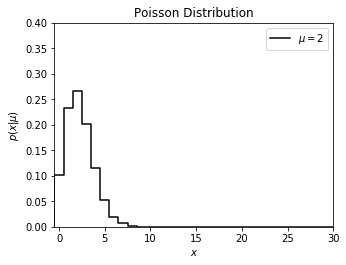

In [35]:
import numpy as np
from scipy.stats import poisson
from matplotlib import pyplot as plt

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Define the distribution parameters to be plotted
mu_values = [2.285]
linestyles = ['-']

#------------------------------------------------------------
# plot the distributions
#   we generate it using scipy.stats.poisson().  Once the distribution
#   object is created, we have many options: for example
#   - dist.pmf(x) evaluates the probability mass function in the case of
#     discrete distributions.
#   - dist.pdf(x) evaluates the probability density function for
#   evaluates
fig, ax = plt.subplots(figsize=(5, 3.75))

for mu, ls in zip(mu_values, linestyles):
    # create a poisson distribution
    # we could generate a random sample from this distribution using, e.g.
    #   rand = dist.rvs(1000)
    dist = poisson(mu)
    x = np.arange(-1, 200)

    plt.plot(x, dist.pmf(x), ls=ls, color='black',
             label=r'$\mu=%i$' % mu, linestyle='steps-mid')

plt.xlim(-0.5, 30)
plt.ylim(0, 0.4)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu)$')
plt.title('Poisson Distribution')

plt.legend()
plt.show()

In [37]:
mu=2.285
poisson.ppf(0.95, mu)

5.0